In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import seaborn as sns
from sklearn.metrics import confusion_matrix, pairwise_distances
import matplotlib.pyplot as plt

sns.set()

#### Euclidean Distance Classifier

In [2]:
class EuclideanClassifier:
    def __init__(self):
        df_in = pd.read_csv("data/train_in.csv", header=None)
        df_out = pd.read_csv("data/train_out.csv", header=None, names=['label'])
        df = df_in.join(df_out)
        # We split our data into small dataFrames and finding their centroids
        digits = dict()
        centers = dict()
        radiuses = dict()
        for i in range(10):
            digits[i] = df[df['label']==i].iloc[:, :-1]
            centers[i] = digits[i].mean()
            radiuses[i] = np.round(digits[i].apply(lambda x:distance.euclidean(x,centers[i]),axis=1).max(), 3)
        self.digits = digits
        self.centers = centers
        self.radiuses = radiuses
        
    def predict_one(self, image):
        dfc = pd.DataFrame(self.centers).T
        dc = dfc.apply(lambda x:distance.euclidean(x, image), axis=1).reset_index()
        result = dc.loc[dc[0] == dc[0].min(),'index'].iloc[0]
        return result
    
    def predict_all(self, tSet):
        return tSet.apply(lambda x:self.predict_one(x), axis=1)

In [3]:
def plot_confusion_matrix(matrix, name):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.heatmap(matrix, cmap="Blues", annot=True, fmt="d", linewidths=.5)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title("Confusion matrix, without normalization")
    fig.savefig(name)
    plt.show()

def get_rate(matrix, distance):
    tp = 0
    for i in range(10):
        tp = tp + matrix[i,i]
    rate = np.round(tp/matrix.sum(), 3)
    print(f"------- Metric: {distance}--------")
    print(f"{tp} digits correctly classified.")
    print(f"Classifier performance rate: %{int(100*rate)}")
    return rate

In [4]:
ec = EuclideanClassifier()

In [5]:
trainingSet = pd.read_csv("data/train_in.csv", header=None)
actualTrainingLabels = pd.read_csv("data/train_out.csv", header=None) 
testSet = pd.read_csv("data/test_in.csv", header=None)
actualTestLabels = pd.read_csv("data/test_out.csv", header=None)

In [6]:
predictedTrainingLabels = ec.predict_all(trainingSet)
cmx = confusion_matrix(actualTrainingLabels, predictedTrainingLabels)
cmx

array([[271,   0,   0,   0,   2,   4,  36,   0,   6,   0],
       [  0, 252,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,   0, 167,   9,   9,   1,   3,   4,   6,   0],
       [  0,   0,   2, 120,   1,   3,   0,   1,   3,   1],
       [  0,   8,   1,   0,  95,   0,   3,   0,   0,  15],
       [  3,   0,   2,   3,   4,  67,   3,   1,   2,   3],
       [ 10,   4,   5,   0,   2,   0, 129,   0,   1,   0],
       [  0,   4,   0,   0,   2,   2,   0, 140,   1,  17],
       [  1,   2,   1,  10,   2,   3,   1,   0, 121,   3],
       [  0,   3,   0,   1,  10,   0,   0,   6,   0, 112]], dtype=int64)

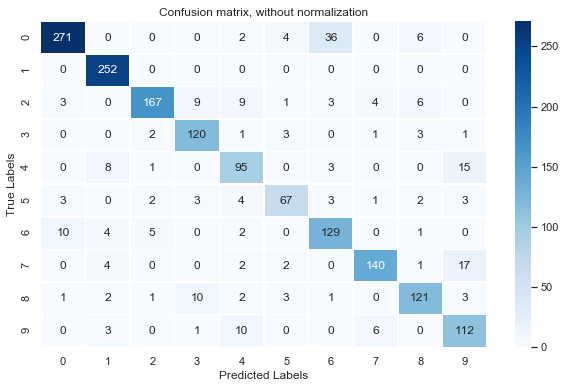

In [7]:
plot_confusion_matrix(cmx, "images/trainingSet.png")

In [8]:
get_rate(cmx, "Euclidean")

------- Metric: Euclidean--------
1474 digits correctly classified.
Classifier performance rate: %86


0.864

In [9]:
predictedTestLabels = ec.predict_all(testSet)
conx = confusion_matrix(actualTestLabels, predictedTestLabels)
conx

array([[178,   0,   3,   2,   4,   2,  23,   1,  10,   1],
       [  0, 120,   0,   0,   0,   0,   1,   0,   0,   0],
       [  2,   0,  69,   6,   8,   1,   0,   2,  13,   0],
       [  3,   0,   3,  61,   1,   8,   0,   0,   1,   2],
       [  1,   3,   3,   0,  69,   0,   1,   1,   0,   8],
       [  3,   0,   0,   6,   3,  38,   1,   0,   0,   4],
       [  7,   0,   2,   0,   2,   1,  78,   0,   0,   0],
       [  0,   2,   1,   0,   5,   0,   0,  50,   0,   6],
       [  3,   2,   0,   6,   3,   3,   0,   0,  73,   2],
       [  0,   5,   0,   0,   8,   0,   0,   5,   2,  68]], dtype=int64)

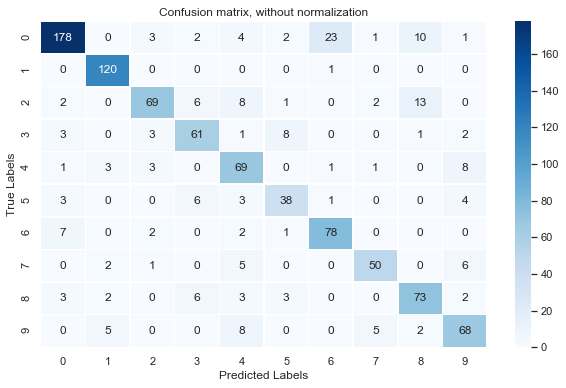

In [10]:
plot_confusion_matrix(conx, "images/testSet.png")

In [11]:
get_rate(conx, "Euclidean")

------- Metric: Euclidean--------
804 digits correctly classified.
Classifier performance rate: %80


0.804

#### Pairwise Distance Classifier

In [12]:
class PairwiseClassifier:
    def __init__(self, method='euclidean'):
        df_in = pd.read_csv("data/train_in.csv", header=None)
        df_out = pd.read_csv("data/train_out.csv", header=None, names=['label'])
        df = df_in.join(df_out)
        df = df.set_index(['label', df.index]).sort_index()
        centers = df.groupby("label").mean()
        radiuses = dict()
        for i in range(10):
            try:
                radiuses[i] = np.round(pairwise_distances(df.loc[i], centers.loc[[i]], metric=method).max(), 3)
            except:
                radiuses[i] = np.round(df.loc[i].apply(lambda x:getattr(distance, method)(x, centers.loc[i]),axis=1).max(), 3)
        self.digits = df
        self.centers = centers
        self.radiuses = radiuses
        self.method = method
        
    def predict_one(self, image): 
        return np.argmin(self.centers.apply(lambda x:getattr(distance, self.method)(x, image),axis=1))
    
    def predict_all(self, tSet):
        return tSet.apply(lambda x:self.predict_one(x), axis=1)
    
    def predict(self, tSet):
        try:
            result = np.argmin(pairwise_distances(tSet, self.centers, metric=self.method),axis=1)
        except:
            result = self.predict_all(tSet)
        return result

In [15]:
def compareMetrics(metrics):
    trainingSet = pd.read_csv("data/train_in.csv", header=None)
    actualTrainingLabels = pd.read_csv("data/train_out.csv", header=None) 
    testSet = pd.read_csv("data/test_in.csv", header=None)
    actualTestLabels = pd.read_csv("data/test_out.csv", header=None)

    TP = []
    rates = []
    for metric in metrics:
        pc = PairwiseClassifier(method=metric)
        confx = confusion_matrix(actualTestLabels, pc.predict(testSet))
        tps = 0
        for i in range(10):
            tps = tps + confx[i,i]
        rate = np.round(tps/confx.sum(), 3)
        
        TP.append(tps)
        rates.append(100*rate)
    
    comparison = {'metric': metrics, \
                  'tp':TP, \
                  'rate_pct': rates}
    df = pd.DataFrame(comparison)
    df = df.sort_values(by=['rate_pct'], ascending=False).reset_index(drop=True)
    return df

In [83]:
def plot_comparison_ALL(table, name):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(x='rate_pct', y='metric', data=table)
    for index, row in table.iterrows():
        ax.text(row.rate_pct, row.name, row.tp, color='black')
    ax.set_xlabel('Performance Percentage')
    ax.set_ylabel('Distance Metrics')
    ax.set_title("Classifier performances ")
    ax.annotate('Correctly classified images number', xy=(80, 7), xytext=(40, 20),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
    #ax.set_xlim(60)
    fig.savefig(name)
    plt.show()

In [84]:
def plot_comparison_top10(table, name):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(x='rate_pct', y='metric', data=table)
    for index, row in table.iterrows():
        ax.text(row.rate_pct, row.name, row.tp, color='black')
    ax.set_xlabel('Performance Percentage')
    ax.set_ylabel('Distance Metrics')
    ax.set_title("Classifier performances ")
    ax.annotate("Correctly classified images' number", xy=(80.3, 5), xytext=(76,8.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
    ax.set_xlim(60)
    fig.savefig(name)
    plt.show()

In [87]:
metrics = ['braycurtis', 'canberra', 'chebyshev', 'correlation', 'dice', 'hamming', \
           'jaccard', 'kulsinski', 'minkowski', 'rogerstanimoto', \
           'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', \
           'yule', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
metrics_df = compareMetrics(metrics)

In [74]:
metrics_df

,metric,tp,rate_pct
0,correlation,806,80.6
1,sqeuclidean,804,80.4
2,l2,804,80.4
3,euclidean,804,80.4
4,minkowski,804,80.4
5,cosine,799,79.9
6,seuclidean,790,79.0
7,chebyshev,784,78.4
8,l1,721,72.1
9,cityblock,721,72.1


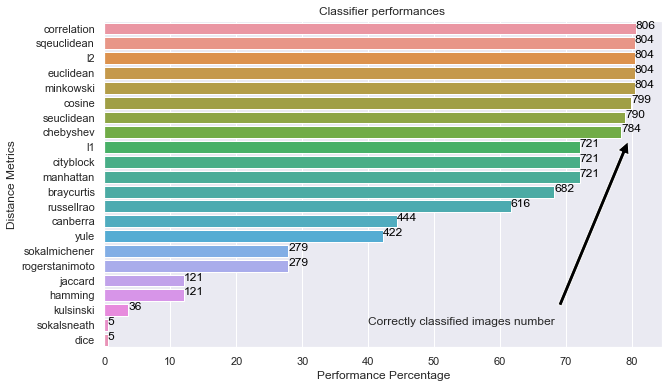

In [85]:
plot_comparison_ALL(metrics_df, "images/all_metrics-try.png")

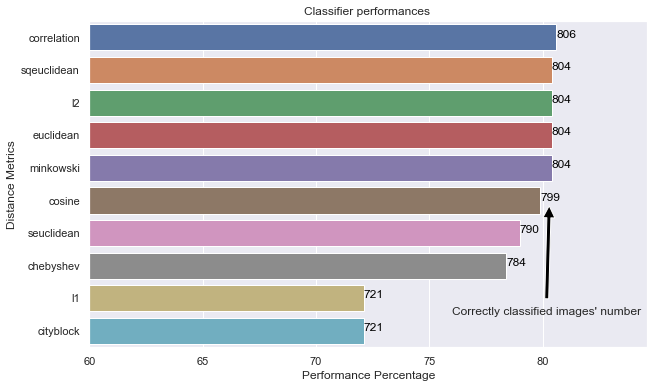

In [86]:
plot_comparison_top10(metrics_df.iloc[:10], "images/top10_metrics.png")